<img src="https://www.climatechangewriters.com/images/2023/03/27/CCW9893490890_large.jpg" style="width:50%; display: block; margin-left: auto; margin-right: auto">
<table style="width:50%">
    <tr>
        <th>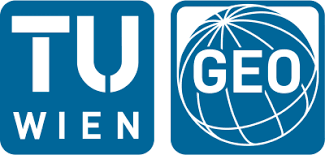</th>
        <th><img src="https://eodc.eu/wp-content/uploads/2018/10/EODC-Logo-Final.png"></th>
    </tr>
</table>

# DestinE Data Lake

The Destination Earth Data Lake (DEDL) combines such disparate data sources in one large virtual database. Moreover, this virtual database comes with a set of tools that facilitates the search for relevant resources as well as the analysis of data by performing computationally expensive operations near to the data source.

This Jupyter Notebook serves as an example of how the DEDL service can help design water management plans to prepare Italian socio-economic systems for prolonged periods of droughts. These conditions will become more prevalent under globally increasing temperatures.

# Use Case 2b: Italy Drought 2022 - 4DMED (ESA Digitial Twin Earth Hydrology precursor activitiy - Sentinel-1 SSM)

After an unusually dry winter, a water management expert is consulted to assess the impact to communal and agricultural water supplies in italy at the end of March 2022.

In case of prolonged absence of rain the expert would require information to prepare a national drought plan. This information should encompass current and future drought intensity as well as a measure of the impact of drought on critical sectors, such as agriculture, industry, and public water. The drought impact per sector is required to estabelish sector-specific mitigating measures that depend on a range of scenarios ranging from ameliorating conditions to severe drought predicted in the forseeable future.

In [1]:
import xarray as xr
from attr import dataclass
import numpy as np
from datetime import datetime

start_drought = datetime(2022, 3, 1)
end_drought = datetime(2022, 8, 31)

xr.set_options(keep_attrs=True)

@dataclass
class Extent:
    min_x: float
    min_y: float
    max_x: float
    max_y: float
    crs: str
    def get_center(self, x_offset=0., y_offset=0.):
        return (np.mean([self.min_y, self.max_y])+x_offset,
                np.mean([self.min_x,self.max_x])+y_offset)

drought_roi = Extent(6.15, 46.90, 19.60, 35.64, crs='EPSG:4326')    # Italy BBOX

### Create Dask Clusters on Central Site and Lumi Bridge
Make use of DEDL client library to create Dask cluster on each site registered in the DEDL.

In [2]:
from dedl_stack_client.authn import DaskOIDC
from dedl_stack_client.dask import DaskMultiCluster
from rich.prompt import Prompt

myAuth = DaskOIDC(username=Prompt.ask(prompt="Username"))
myDEDLClusters = DaskMultiCluster(auth=myAuth)

Username:

The DaskMultiCluster class provides an interface to interact with multiple Dask Gateway instances at once. However, each gateway instance can be consumed separately using the default Dask Gateway API. Gateway objects can be accessed via the gateway attribute, representing a dictionary of available gateway instances.

In [3]:
myDEDLClusters.new_cluster()

Create new cluster for Central Site


/home/creimer/micromamba/envs/dedl_flood/lib/python3.11/site-packages/distributed/client.py:1401: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.7  | 1.0.5     | None    |
| toolz   | 0.12.1 | 0.12.0    | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Create new cluster for LUMI Bridge


## Access Data from DEDL Service

Using the DEDL package, data can be accessed from various services. In this example, data is retrieved from the EU-funded 4-Dimensional Mediterranean Earth Data (4DMED) Project (research project), the Copernicus Land Monitoring service (CLMS), and the European Centre for Medium-Range Weather Forecasts (ECMWF

- The 4DMED Project aims to develop high resolution daily Earth Observations data sets targeting multiple aspects of the Mediterranean terrestrial water cycle. For this case study we will use the EU’s Copernicus Sentinel-1 satellite microwave imaging data (ESA Digitial Twin Earth Hydrology precursor activitiy). Microwave imaging is a technique that is relatively unaffected by cloud cover and is especially sensitive to variations in near surface water content. This dataset is used to evaluate drought severeness at the end of March 2022.

- The CLMS is queried for the CORINE ('Coordination of information on the environment') Land Cover inventory. The original purpose of this data set serves environmental policy development and consists of 44 classes of land cover in five main units (artificial, agriculture, forests and semi-natural, wetlands, and water). It combines a number of sources, among which Landsat-5, Landsat-7, and ESA Sentinel-2 satellite imaging data in the most recent years. This dataset will highlight which sectors will be most likely drought impacted under the predicted scenario.
  
- The ECMWF catalogue is used to obtain the multi-decadal ERA5-Land dataset. This product is a reanalysis dataset that gives insight in the seasonal variation of land variables by averaging data over multiple decades with a 9km spatial resolution. The ERA5-Land data is retrieved to estimate the development of drought over the months following the 30<sup>th</sup> of March 2022. This dataset is for demonstration purposes only, and will be replaced with a high resolution soil moisture prediction dataset in the future.

Additionally, the DEDL service allows data uploads by the user. These capabilities of the DEDL services are examplified below.

### Login to DEDL storage service at central site and bridge

In [4]:
import s3fs

S3_BASE_URL = "https://s3.{site_name}.data.destination-earth.eu"

S3_URL_CENTRAL = S3_BASE_URL.format(site_name="central")
S3_URL_LUMI = S3_BASE_URL.format(site_name="lumi")

s3_central = s3fs.S3FileSystem(
    endpoint_url=S3_URL_CENTRAL,
    key=Prompt.ask(prompt="S3 Key"),
    secret=Prompt.ask(prompt="S3 Secret", password=True),
    use_ssl=True,
)

s3_lumi = s3fs.S3FileSystem(
    endpoint_url=S3_URL_LUMI,
    key=Prompt.ask(prompt="S3 Key"),
    secret=Prompt.ask(prompt="S3 Secret", password=True),
    use_ssl=True,
)

S3 Key:

S3 Secret:

S3 Key:

S3 Secret:

### 4DMED Soil Moisture (soil moisture retrieval from Sentinel-1)

Datacube holding the 4MED Soil Moisture retrieved from Sentinel-1 uploaded to a user bucket on centrals site.

In [5]:
sm_sat_italy_summer_22 = xr.open_zarr(
    store=s3fs.S3Map(
        root=f"demo/dedl-user/4dmed_italy.zarr", s3=s3_central, check=False
    ),
    decode_coords="all",
)["SM"].assign_attrs(location="central")
sm_sat_italy_summer_22

<xarray.DataArray 'SM' (date: 184, latitude: 1122, longitude: 1342)>
dask.array<open_dataset-SM, shape=(184, 1122, 1342), dtype=float32, chunksize=(23, 141, 168), chunktype=numpy.ndarray>
Coordinates:
  * date         (date) datetime64[ns] 2022-03-01 2022-03-02 ... 2022-08-31
  * latitude     (latitude) float64 36.64 36.65 36.66 ... 46.71 46.72 46.73
  * longitude    (longitude) float64 6.454 6.463 6.472 ... 18.5 18.51 18.52
    spatial_ref  int64 ...
Attributes:
    location:  central

### DT output
Predicted soil moisture based on ERA-5 to simulate DT outputs.

In [6]:
sm_mdl_22 = xr.open_zarr(
    store=s3fs.S3Map(
        root=f"demo/dedl-drought/modelled_sm.zarr", s3=s3_lumi, check=False
    ),
    decode_coords="all",
)["swvl1"].sel(time=slice(start_drought, end_drought)).assign_attrs(location="lumi")
sm_mdl_22

<xarray.DataArray 'swvl1' (time: 184, latitude: 1801, longitude: 3600)>
dask.array<getitem, shape=(184, 1801, 3600), dtype=float32, chunksize=(100, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude    (longitude) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 2022-03-01 2022-03-02 ... 2022-08-31
Attributes:
    location:  lumi

### Corine LandCover

Corine LandCover map of 2018 converted into a zarr datastore.

In [7]:
corine_italy = xr.open_zarr(
    store=s3fs.S3Map(
        root=f"demo/dedl-drought/corine_italy.zarr", s3=s3_central, check=False
    )
)["corine_lc"].assign_attrs(location="central")
corine_italy = corine_italy.squeeze()
corine_italy

<xarray.DataArray 'corine_lc' (latitude: 16981, longitude: 16878)>
dask.array<getitem, shape=(16981, 16878), dtype=float32, chunksize=(1062, 1055), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 49.95 49.94 49.94 49.94 ... 32.3 32.29 32.29
    lc         int64 1
  * longitude  (longitude) float64 1.818 1.819 1.82 1.821 ... 19.36 19.36 19.36
Attributes:
    AREA_OR_POINT:       Area
    DESCRIPTION:         clc18
    RepresentationType:  THEMATIC
    grid_mapping:        spatial_ref
    location:            central

## Preprocess the Data

The raw data requires preprocessing to be able to extract relevant information. 

This task is, however, computationally demanding and requires specialized IT infrastructure. The DEDL services are designed to cope with these computational limitations at the user's side by implementing distributed computation capabilities. This feature runs the task near to the source of the data. The user can therefore execute the script as if they would have performed it on their own local device (laptop, pc, or tablet). However, in reality, the computationally demanding tasks are executed at the high-performance computing facilities of DEDL. The DEDL services lower these barriers by performing these processing step close at the source of the data. Besides delegating computational intense processes to dedicated high performance clusters, this prevents redundant data transfer that cause further slowdown of the workflow. Combined, this toolchain provides an optimal user experience uninhibited by the user's hardware.

In [8]:
from rasterio.enums import Resampling

def normalize(da: xr.DataArray) -> xr.DataArray:
        da_min = da.min()
        return (da - da_min) / (da.max() - da_min)

#### load 4D MED catchment from user workspace for clipping

In [9]:
import geopandas as gpd

catchment_file = s3_central.open("demo/dedl-user/4dmed_catchment/catch_med.geojson", 'rb')
catchment_df = gpd.read_file(catchment_file)

#### Preprocess 4DMED Soil Moisture

Compute mean soil moisture and resample from swath geometry to Web Mercator projection for final visualisation.

In [10]:
sm_sat = normalize(sm_sat_italy_summer_22.resample(date='15D').mean('date'))
sm_sat

<xarray.DataArray 'SM' (date: 13, latitude: 1122, longitude: 1342)>
dask.array<truediv, shape=(13, 1122, 1342), dtype=float32, chunksize=(1, 141, 168), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 36.64 36.65 36.66 ... 46.71 46.72 46.73
  * longitude    (longitude) float64 6.454 6.463 6.472 ... 18.5 18.51 18.52
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2022-03-01 2022-03-16 ... 2022-08-28
Attributes:
    location:  central

### Central Site Dask Dashboard

In [11]:
from IPython import display
CENTRAL_DASHBOARD_URL = myDEDLClusters.cluster["central"].dashboard_link
display.IFrame(CENTRAL_DASHBOARD_URL, width="100%", height=800)

compute mean soil moisture over Italy and reproject to Web Mercator.

In [12]:
sm_sat_ = myDEDLClusters.compute(sm_sat, sync=True)
sm_sat_reprojected = sm_sat_.rio.write_crs('EPSG:4326') \
    .rio.reproject('EPSG:3857', resampling=Resampling.bilinear) \
        .rio.write_nodata(-9999., inplace=True)
sm_sat_reprojected = sm_sat_reprojected.fillna(-9999.)

#### Compute predicted soil moisture of simluated DT outputs (ERA5)

In [13]:
def clip_dataset_to_extent(ds, geodf):
    roi_extent = geodf.total_bounds
    mask_lon = (ds.longitude >= roi_extent[0]) & (ds.longitude <= roi_extent[2])
    mask_lat = (ds.latitude >= roi_extent[1]) & (ds.latitude <= roi_extent[3])
    return ds.where(mask_lon & mask_lat, drop=True)

sm_mdl_italy_summer_22 = clip_dataset_to_extent(sm_mdl_22, catchment_df)
sm_mdl_mm = normalize(sm_mdl_italy_summer_22.resample(time='15D').mean('time'))
sm_mdl_mm

<xarray.DataArray 'swvl1' (time: 13, latitude: 199, longitude: 432)>
dask.array<truediv, shape=(13, 199, 432), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 48.2 48.1 48.0 47.9 ... 28.7 28.6 28.5 28.4
  * longitude    (longitude) float64 -5.6 -5.5 -5.4 -5.3 ... 37.2 37.3 37.4 37.5
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2022-03-01 2022-03-16 ... 2022-08-28
Attributes:
    location:  lumi

### LUMI Bridge Dask Dashboard

In [14]:
from IPython import display
LUMI_DASHBOARD_URL = myDEDLClusters.cluster["lumi"].dashboard_link
display.IFrame(LUMI_DASHBOARD_URL, width="100%", height=800)

In [15]:
sm_mdl_mm_ = myDEDLClusters.compute(sm_mdl_mm, sync=True)
sm_mdl_mm_ = sm_mdl_mm_.rename({"longitude":"x", "latitude":"y"})
sm_mdl_mm_

<xarray.DataArray 'swvl1' (time: 13, y: 199, x: 432)>
array([[[           nan,            nan,            nan, ...,
         4.95624989e-01, 5.05377710e-01, 5.05289257e-01],
        [           nan,            nan,            nan, ...,
         4.98278648e-01, 5.05719900e-01, 5.04702032e-01],
        [           nan,            nan,            nan, ...,
         4.98845220e-01, 4.99287874e-01, 5.01554728e-01],
        ...,
        [1.45745631e-02, 1.39832608e-02, 1.33316610e-02, ...,
         2.67294161e-02, 2.56185140e-02, 2.19189320e-02],
        [1.52864046e-02, 1.41106825e-02, 1.29277352e-02, ...,
         1.92238614e-02, 1.73848439e-02, 7.18897860e-03],
        [1.53837875e-02, 1.38954492e-02, 1.26969125e-02, ...,
         9.20688827e-03, 8.99268687e-03, 1.60973500e-02]],

       [[           nan,            nan,            nan, ...,
         4.69979793e-01, 4.85048234e-01, 4.85448718e-01],
        [           nan,            nan,            nan, ...,
         4.72934455e-01, 4.82996464e-01, 4.84338403e-01],
        [           nan,            nan,            nan, ...,
         4.70457137e-01, 4.73388165e-01, 4.77756202e-01],
...
        [2.17066234e-04, 1.27476989e-04, 1.26961109e-04, ...,
         6.95615029e-03, 5.53349871e-03, 4.58475715e-03],
        [1.88292208e-04, 1.13663154e-04, 6.00127714e-05, ...,
         5.79985883e-03, 4.64792270e-03, 2.26913579e-03],
        [1.89209313e-04, 4.94661072e-05, 1.07759315e-05, ...,
         2.73456424e-03, 2.71364325e-03, 4.87215351e-03]],

       [[           nan,            nan,            nan, ...,
         2.49551028e-01, 2.57777184e-01, 2.49325544e-01],
        [           nan,            nan,            nan, ...,
         2.71968335e-01, 2.52792597e-01, 2.49995947e-01],
        [           nan,            nan,            nan, ...,
         2.72561997e-01, 2.56124914e-01, 2.37403139e-01],
        ...,
        [9.22438316e-03, 8.41876771e-03, 7.54329516e-03, ...,
         2.11397820e-21, 2.11397820e-21, 2.11397820e-21],
        [9.69425496e-03, 8.29839893e-03, 5.21006295e-03, ...,
         2.11397820e-21, 2.11397820e-21, 2.11397820e-21],
        [9.53669939e-03, 7.30277132e-03, 1.85025041e-03, ...,
         2.11397820e-21, 2.11397820e-21, 2.11397820e-21]]], dtype=float32)
Coordinates:
  * y            (y) float64 48.2 48.1 48.0 47.9 47.8 ... 28.7 28.6 28.5 28.4
  * x            (x) float64 -5.6 -5.5 -5.4 -5.3 -5.2 ... 37.2 37.3 37.4 37.5
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2022-03-01 2022-03-16 ... 2022-08-28
Attributes:
    location:  lumi

#### Corine Land Cover

Resample data to coarser resolution and provide only major LC classes for visulisation.

In [16]:
def preprocess_corine(lc: xr.DataArray) -> xr.DataArray:
    steps = 500 // 100
    downsampled = lc.coarsen({'latitude': steps, 'longitude': steps}, boundary='trim').median()
    downsampled = xr.apply_ufunc(
        np.floor,
        downsampled/100.,
        dask="allowed",
    )
    return downsampled.transpose('latitude', 'longitude')


In [17]:
lc = preprocess_corine(corine_italy)
lc = lc.rename({"longitude":"x", "latitude":"y"})
lc

<xarray.DataArray 'corine_lc' (y: 3396, x: 3375)>
dask.array<floor, shape=(3396, 3375), dtype=float32, chunksize=(213, 211), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 49.94 49.94 49.93 49.93 49.92 ... 32.31 32.31 32.3 32.3
    lc       int64 1
  * x        (x) float64 1.82 1.825 1.831 1.836 ... 19.34 19.35 19.35 19.36
Attributes:
    AREA_OR_POINT:       Area
    DESCRIPTION:         clc18
    RepresentationType:  THEMATIC
    grid_mapping:        spatial_ref
    location:            central

compute CorineLC classes over Italy on central site.

In [18]:
lc_ = myDEDLClusters.compute(lc, sync=True)
lc_ = lc_.fillna(-9999.)

## Inspect Data

The DEDL service provides functionality to quickly visualize the previously processed data. These features not only help to validate the queried data, and the applied data transformations, but also allows an assessment of the current situation of soil moisture with only minimal effort.  More so, it marks the starting point of exploratory data analysis signified by the formulation of hypotheses that can be quickly tested. With the available Sentinel-1 soil moisture data, the expert can easily spot that water stocks are already severely reduced in some regions, such as the Po Valley (Emilia-Romagna and Veneto) at the end of March 2022. More so, the CORINE land cover data suggests that reduced water tables are especially prevalent in areas with an extensive agricultural component. This raises the question how agricultural yield will fair if drought conditions prevail over the coming months.


### Reproject Corine LC data

In [19]:
lc_reprojected = lc_.rio.write_crs('EPSG:4326').rio.reproject('EPSG:3857', nodata=-9999.)
lc_reprojected

<xarray.DataArray 'corine_lc' (y: 3847, x: 2851)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)
Coordinates:
  * x            (x) float64 2.027e+05 2.034e+05 ... 2.154e+06 2.155e+06
  * y            (y) float64 6.437e+06 6.436e+06 ... 3.803e+06 3.802e+06
    lc           int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    DESCRIPTION:         clc18
    RepresentationType:  THEMATIC
    grid_mapping:        spatial_ref
    location:            central
    _FillValue:          -9999.0

scale data for visualisation purposes

In [20]:
sm_sat_reprojected.max()

<xarray.DataArray 'SM' ()>
array(1., dtype=float32)
Coordinates:
    spatial_ref  int64 0
Attributes:
    location:    central
    _FillValue:  -9999.0

In [21]:
import leafmap
import matplotlib as mpl

m = leafmap.Map(center=drought_roi.get_center(x_offset=4, y_offset=-5),
                zoom=7, height=600)

norm = mpl.colors.Normalize(1,10)
norm_index = norm([1,2,3,4,5])
cmap = mpl.cm.get_cmap('tab10')
leg_cols = [mpl.colors.rgb2hex(cmap(c)) for c in norm_index]

current_sm = sm_sat_reprojected.sel(date=start_drought)*100.

m.split_map(
    lc_reprojected,
    current_sm,
    left_args={
            "layer_name": "CorineLC",
            "colormap": "tab10",
            "vmin": 1,
            "vmax": 10,
            "nodata": -9999.,
        },
    left_label="Corine LandCover 2018",
    right_args={
        "layer_name": "Sentinel-1 SSM",
        "colormap": "RdBu",
        "nodata": -999900.,
        "vmin": 0.,
        "vmax": 100.,
    },
    right_label="Soil Moisture (Sentinel-1)"
)
m.add_legend(title="Corine LC",
             position='bottomleft',
             layer_name="CorineLC",
             colors=leg_cols,
             labels=['Artificial surfaces',
                     'Agricultural areas',
                     'Forest and seminatural areas',
                     'Wetlands',
                     'Water bodies'])
m

Map(center=[45.269999999999996, 7.875], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

## Predicting Drought

The DEDL services provide also generic modelling components to enable an user-specific predictive assessment of future conditions. In this regard the water management expert is interested in the soil moisture content over the months starting at April and ending in August. 

### Reproject data

In [22]:
sm_mdl_mm_reprojected = sm_mdl_mm_.rio.reproject('EPSG:3857').rio.write_nodata(-9999., inplace=True)
sm_mdl_mm_reprojected = sm_mdl_mm_reprojected.fillna(-9999.)

In [23]:
time_dim_len = sm_mdl_mm_reprojected.shape[0]
for day in range(0, time_dim_len):
    fpath_str = f"./{day}.tif"
    sm_mdl_mm_reprojected[day,:].rio.to_raster(fpath_str,
                                  driver="COG",
                                  overview_count=10)

In [24]:
import leafmap
from localtileserver import get_leaflet_tile_layer

m = leafmap.Map(center=drought_roi.get_center(),
                zoom=5, height=600)

layer_dict = {}
date_vals = np.datetime_as_string(sm_mdl_mm_reprojected["time"].values, unit='D')
for day in range(0, time_dim_len):
    layer_dict[date_vals[day]]= get_leaflet_tile_layer(f"./{day}.tif",
                                                       colormap="RdBu",
                                                       indexes=[1],
                                                       nodata=-9999.,
                                                       vmin=0,
                                                       vmax=1,
                                                       opacitiy=0.5)
m.add_time_slider(layer_dict,
                  layer="DT - Soil Moisture",
                  time_interval=2)
m

Map(center=[41.269999999999996, 12.875], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

The simulated DT outputs indicate that intensified drought can be expected for the six months following the beginning of this survey. Moreover the simulated results suggest that especially agricultural areas will be inflicted by drought.The water management expert uses this scenario to preemptively call on water preserving measures and estabelish rationing plans whilst identifying the most critical systems. Preserving measures can consist of changing to crops that are more well adapted to prolonged drought, which include drought adapted varieties of corn, wheat, and rice and already drough-tolerant soy. Alternatively, a reduction of hydro-electrical energy production could reduce consumption of water. Whereas proactive rationing can reduce the overall pressure on harvests by more effective spreading of water consumption restrictions over longer periods, which reduces the risk of total crop failure.

### Retrospective Analysis of the DEDL Services

The Italy drought event of 2022 severely affected water supply in the regions Emilia-Romagna and Veneto along the river Po. These regions are known for their high agricultural yields and a significant proportion of the European crop production takes place here. Estimates suggest that ~6 billion euro of produce were damaged during this particular drought event. Besides dwindling water supplies, low ground water levels caused saltwater intrusion into fresh water aquifers in some of the coastal regions. This compounding of effects resulted in water shortages and required water rationing at local administrative levels in Italy. Predicted future warming will likely exacerbate the frequency and severity of drought effect in the coming years and clearly stipulates the need for early warning systems as demonstrated here.

In [26]:
time_dim_len = sm_sat_reprojected.shape[0]
for day in range(0, time_dim_len):
    fpath_str = f"./sm_{day}.tif"
    sm_sat_reprojected[day,:].rio.to_raster(fpath_str,
                                driver="COG",
                                overview_count=10)

In [31]:
import leafmap
from localtileserver import get_leaflet_tile_layer

m = leafmap.Map(center=drought_roi.get_center(x_offset=1),
                zoom=6, height=600)

layer_dict = {}
date_vals = np.datetime_as_string(sm_sat_reprojected["date"].values, unit='D')
for day in range(0, time_dim_len):
    layer_dict[date_vals[day]]= get_leaflet_tile_layer(f"./sm_{day}.tif",
                                                       colormap="RdBu",
                                                       indexes=[1],
                                                       nodata=-9999.,
                                                       vmin=0,
                                                       vmax=1,
                                                       opacitiy=0.5)
m.add_time_slider(layer_dict,
                  layer="DT - Soil Moisture",
                  time_interval=2)
m

Map(center=[42.269999999999996, 12.875], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

### Shutdown Dask Cluster to free up resources

In [32]:
myDEDLClusters.shutdown()